In [4]:
import pandas as pd

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [14]:
queryStudy='SRP067759'

In [15]:
sraDumpDf=pd.read_pickle('/home/jovyan/efs/all_seq/meta_data/sra_dump.pickle')

In [68]:
vcfDf=pd.read_csv('/home/jovyan/efs/all_seq/meta_data/All_20170710.f1_byte2_not_00.vcf.gz',comment='#',sep='\s+',header=None)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [69]:
vcfDf.columns=['CHROM', 'POS' ,  'ID' , 'REF' ,'ALT', 'QUAL' , 'FILTER', 'INFO']


In [70]:
vcfDf['CHROM']=vcfDf['CHROM'].astype(str)
vcfDf['POS']=vcfDf['POS'].astype(int)

In [17]:
hitSrrs=sraDumpDf.index[sraDumpDf.Study==queryStudy]

In [18]:
FilePostFix='XXXX'

In [19]:
filesToLoadIn=(hitSrrs.str[:-len((FilePostFix))]+FilePostFix).unique()

In [20]:
#Run_db	Run_digits
hitSrrMetaDf=pd.Series( hitSrrs).str.extract('(?P<Run_db>\wRR)(?P<Run_digits>\d+)')

In [21]:
hitSrrMetaDf['Run_digits']=hitSrrMetaDf['Run_digits'].astype(int)

In [22]:
baseDir="/home/jovyan/efs/all_seq/snp/mergedBySrr/"

In [24]:
myL=[]
for fileToLoadIn in filesToLoadIn:
    %time tmpDf=pd.read_pickle(baseDir+fileToLoadIn+'.pickle.gz')
    print (tmpDf.memory_usage().sum()/10.0**9)
    m_runDigits=tmpDf.index.get_level_values('Run_digits').isin(hitSrrMetaDf['Run_digits'])
    m_runDb=tmpDf.index.get_level_values('Run_db')==fileToLoadIn[:3]#.isin(hitSrrMetaDf['Run_digits'])
    tmpDf_sub=tmpDf[m_runDigits&m_runDb].copy()
    del tmpDf
    myL.append(tmpDf_sub)
    break

CPU times: user 12.9 s, sys: 1.2 s, total: 14.1 s
Wall time: 14.5 s
1.385616236


In [25]:
mergedDf=pd.concat(myL,axis=0)

In [132]:
queryChr,queryPos="7",140753336
windowSize=20

In [162]:
m_chrom=mergedDf.index.get_level_values('Chr')=='7'

In [163]:
m_pos_lower=(mergedDf.index.get_level_values('Pos')>(queryPos-windowSize))
m_pos_upper=(mergedDf.index.get_level_values('Pos')<(queryPos+windowSize))

In [164]:
mergedDf_sub=mergedDf[m_pos_lower&m_chrom&m_pos_upper]

In [178]:
mergedDf_rd=mergedDf_sub[mergedDf_sub['ReadDepth']>=2]

In [180]:
mergedDf_rd_reset=mergedDf_rd.reset_index()#.set_index(['Run_db','Run_digits'])

In [181]:
mergedDf_rd_reset['Chr']=mergedDf_rd_reset['Chr'].astype(str)

In [182]:
mergedDf_rd_reset['Chr']=mergedDf_rd_reset['Chr'].astype(str)
mergedDf_rd_reset['Pos']=mergedDf_rd_reset['Pos'].astype(int)

In [183]:
mutlI=mergedDf_rd_reset.set_index(['Chr','Pos']).index

In [184]:
posToRefS=vcfDf.set_index(['CHROM','POS'])['REF']

posToRefS=posToRefS.str[0].groupby(['CHROM','POS']).first()

In [185]:
refS=posToRefS[mutlI].values

In [186]:
mergedDf_rd_reset['Ref']=refS

In [187]:
mergedDf_rd_reset['AltBase']=mergedDf_rd_reset.Ref!=mergedDf_rd_reset.base

In [188]:
countDf=mergedDf_rd_reset.groupby(['Chr','Pos','AltBase']).size().unstack().fillna(0)

In [189]:
afDf=(countDf.T/countDf.T.sum(axis=0)).T

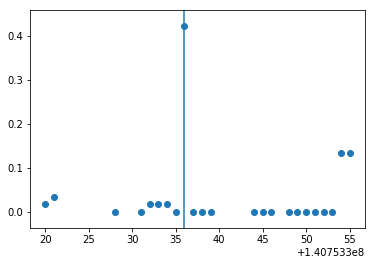

In [190]:
%matplotlib inline
import matplotlib.pyplot as plt
y=afDf[True]
x=afDf.index.get_level_values('Pos')
plt.scatter(x=x,y=y)
plt.axvline(queryPos)